In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import torch
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms.v2 import ToImage, ToDtype
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from engine import Tensor, draw_dot
import nn
import optim

In [8]:
class ToNPTensor(torch.nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

    def forward(self, x):
        return Tensor(x.numpy().reshape(-1, 1, 28, 28)*2.0 - 1.0)

class ToOneHot(torch.nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)

    def forward(self, y):
        y = torch.tensor(y)
        return F.one_hot(y, 10)

transforms = torch.nn.Sequential(
    ToImage(),
    ToDtype(torch.float32, scale=True)
)

target_transforms = torch.nn.Sequential(
    ToOneHot()
)

to_np_tensor = ToNPTensor()

bs = 1024
dataset = MNIST("dataset", download=True, transform=transforms, target_transform=target_transforms)
dataloader_train = DataLoader(Subset(dataset, range(int(0.8*len(dataset)))), batch_size=bs)
dataloader_val = DataLoader(Subset(dataset, range(int(0.8*len(dataset)), len(dataset))), batch_size=bs)

(1, 28, 28) (1024, 10)
-1.0 1.0
(1024, 10)
Label:  data 2.4420882638897217, grad 1.0 op *
Number of parameters 116234


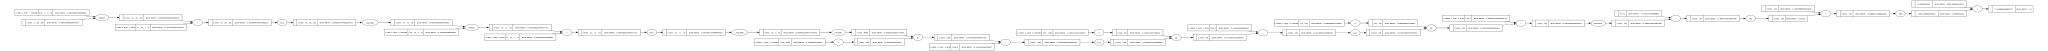

In [9]:
model = nn.Sequential(
    nn.Conv2d(1, 16, name="Conv Layer 1"),
    nn.ReLU(),
    nn.AvgPooling((2, 2)),
    nn.Conv2d(16, 32, name="Conv Layer 2"),
    nn.ReLU(),
    nn.AvgPooling((2, 2)),
    nn.Flatten(),
    nn.Linear(800, 128, name="Linear Layer 3"),
    nn.ReLU(),
    nn.Linear(128, 64, name="Linear Layer 4"),
    nn.ReLU(),
    nn.Linear(64, 10, name="Linear Layer 5"),
    nn.Softmax()
)

def ce_loss_func(y_true: Tensor, y_pred: Tensor) -> Tensor:
    m = y_true.shape[0]
    t1 = y_true*((y_pred + 1.e-12).log())
    return (-1.0 / m) * t1.sum()

x, y = next(iter(dataloader_train))
x = to_np_tensor(x)
y = Tensor(y)
print(x[0].shape, y.shape)
print(x[0].data.min(), x[0].data.max())
print(model(x).shape)
loss = ce_loss_func(y, model(x))
loss.backward()
print(loss)
print("Number of parameters", sum(p.data.size for p in model.parameters()))
draw_dot(loss)

In [10]:
epochs = 30
lr = 0.001

loss_hist = []
acc_hist = []

# optimizer = optim.SGD(model.parameters(), lr, 0.001)
optimizer = optim.Adam(model.parameters(), lr)

pbar = tqdm(range(epochs))
for k in pbar:
    loss_train = 0.0
    acc_train = 0.0
    for i, (x, y) in enumerate(dataloader_train):
        x = to_np_tensor(x)
        y = Tensor(y)

        y_pred = model(x)

        loss = ce_loss_func(y, y_pred)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        loss_train += loss.data
        acc_train += np.sum(y_pred.data.argmax(-1) == y.data.argmax(-1)) / y.shape[0]
    loss_train = loss_train / (i + 1)
    acc_train = acc_train / (i + 1)

    loss_val = 0.0
    acc_val = 0.0
    for i, (x, y) in enumerate(dataloader_val):
        x = to_np_tensor(x)
        y = Tensor(y)

        y_pred = model(x)

        loss_val += ce_loss_func(y, y_pred).data
        acc_val += np.sum(y_pred.data.argmax(-1) == y.data.argmax(-1)) / y.shape[0]

    loss_hist.append(loss_val/(i + 1))
    acc_hist.append(acc_val/(i + 1))
    pbar.set_description(f"loss train: {loss_train}, acc train: {100*acc_train} loss val: {loss_val/(i + 1)}, acc val: {100*acc_val/(i + 1)}")

  0%|          | 0/30 [00:00<?, ?it/s]

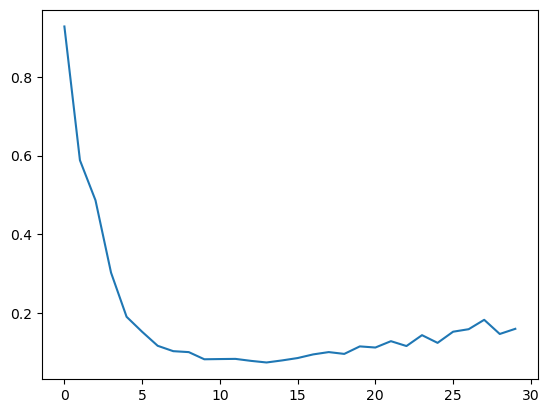

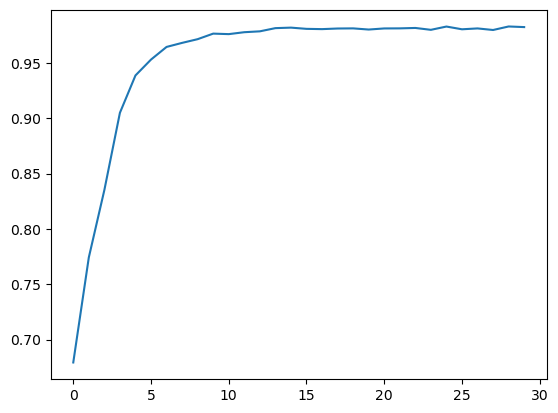

In [11]:
plt.plot(loss_hist)
plt.show()

plt.plot(acc_hist)
plt.show()